# Regression with ML: Mercari Price Prediction

## Goal
To find best price for each second-hand products which users uplod on mercari   
## 1. Data Preparation

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = "https://drive.google.com/open?id=1fT2O4okInxqZ0quXJkI4oJfLjK1Q_tQH"

In [7]:
fluff, id = link.split('=')
print (id)

1fT2O4okInxqZ0quXJkI4oJfLjK1Q_tQH


In [9]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile("train.tsv")  
mercari = pd.read_csv("train.tsv", delimiter="\t")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
submission = pd.read_csv("sample_submission.csv")
submission.head()

,test_id,price
0,0,26.738
1,1,26.738
2,2,26.738
3,3,26.738
4,4,26.738


In [10]:
#mercari = pd.read_csv("train.tsv", delimiter="\t")
mercari.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3.0,Men/Tops/T-shirts,NaN,10.0,1.0,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3.0,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0.0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1.0,Women/Tops & Blouses/Blouse,Target,10.0,1.0,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1.0,Home/Home Décor/Home Décor Accents,NaN,35.0,1.0,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1.0,Women/Jewelry/Necklaces,NaN,44.0,0.0,Complete with certificate of authenticity


In [0]:
mercari_test = pd.read_csv("test.tsv", delimiter="\t")
mercari_test.head()

## 2. Target and Feature Split

In [16]:
mercari_price = mercari[["price", "train_id"]]
mercari_price.head()

,price,train_id
0,10.0,0
1,52.0,1
2,10.0,2
3,35.0,3
4,44.0,4


In [18]:
mercari_price.shape

(1483904, 2)

In [11]:
mercari_price.drop(labels=[511535, 861230, 1224924, 1264242], inplace=True)
mercari_price.reset_index(drop=True, inplace=True)
mercari_price.shape

(1485242,)

In [17]:
mercari.drop("price", axis=1, inplace=True)
mercari.head()

,train_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3.0,Men/Tops/T-shirts,no_brand,1.0,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3.0,Electronics/Computers & Tablets/Components & P...,Razer,0.0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1.0,Women/Tops & Blouses/Blouse,Target,1.0,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1.0,Home/Home Décor/Home Décor Accents,no_brand,1.0,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1.0,Women/Jewelry/Necklaces,no_brand,0.0,Complete with certificate of authenticity


In [19]:
mercari.shape

(1483904, 7)

## 3. Convert Data Type

In [14]:
mercari.dtypes

train_id              object
name                  object
item_condition_id    float64
category_name         object
brand_name            object
shipping             float64
item_description      object
dtype: object

In [15]:
len(mercari["brand_name"].unique())

4810

## 4. Missing Value

In [35]:
mercari.isnull().any()

train_id             False
name                  True
item_condition_id     True
category_name         True
brand_name            True
price                 True
shipping              True
item_description      True
dtype: bool

In [36]:
mercari.isnull().sum()

train_id                  0
name                      1
item_condition_id         1
category_name          6337
brand_name           633668
price                     1
shipping                  1
item_description          5
dtype: int64

I will cut 4 records which have null value in column "item_description".

In [37]:
mercari[mercari["item_description"].isnull()]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
511535,511535,Shoes for Michelle,4.0,Kids/Girls 0-24 Mos/Shoes,NaN,9.0,0.0,NaN
861230,861230,Lipgloss,4.0,Beauty/Makeup/Lips,NaN,49.0,0.0,NaN
1224924,1224924,Disney Minnie Head band,3.0,Women/Women's Accessories/Hair Accessories,Disney,9.0,0.0,NaN
1264242,1264242,For Bianca,3.0,Women/Women's Accessories/Scarves & Wraps,NaN,10.0,1.0,NaN
1482535,"y, stainless steel back""",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
mercari.drop(labels=[511535, 861230, 1224924, 1264242], inplace=True)
mercari.shape

(1485242, 7)

In [0]:
mercari["brand_name"].fillna(value="no_brand", inplace=True)

In [0]:
mercari["category_name"].fillna(value="no_category", inplace=True)

In [14]:
mercari.isnull().sum()

train_id             0
name                 1
item_condition_id    1
category_name        0
brand_name           0
price                1
shipping             1
item_description     5
dtype: int64

In [41]:
len(mercari)

1484806

In [15]:
mercari.dropna(inplace=True)
len(mercari)
mercari.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

# Policy for each Features
1. Sequencial  Category Data
    - item_condition_id -> MultiLabelEncode
    
    
2. Discrete Category Data
    - shipping -> Binary
    - category_name -> Multiple-One-Hot
    - brand_name -> One-Hot
    
      
3. NLP Data
    - name
    - item_description

## 5. Numerical Values: Outlier Exclusion

In [48]:
mercari_price.head()

,price,train_id
0,10.0,0
1,52.0,1
2,10.0,2
3,35.0,3
4,44.0,4


In [49]:
mercari_price.isnull().sum()

price       0
train_id    0
dtype: int64

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


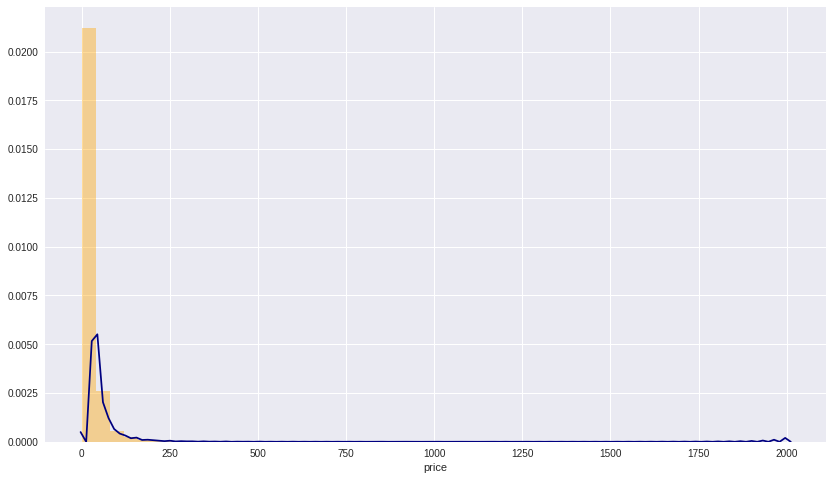

In [51]:
plt.figure(figsize=(14,8))
sns.distplot(mercari_price["price"], hist_kws={"color": "Orange"}, kde_kws={"color": "Navy"})
plt.show();

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


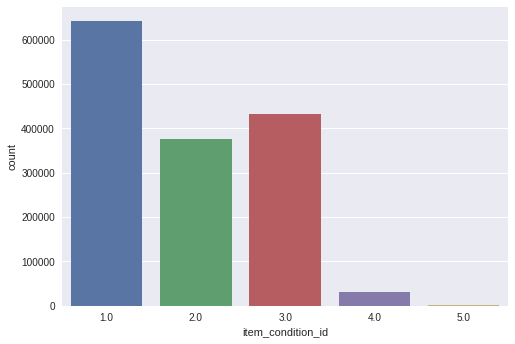

In [52]:
# the condition of the items provided by the seller
sns.set(style="darkgrid")
ax = sns.countplot(x="item_condition_id", data=mercari)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


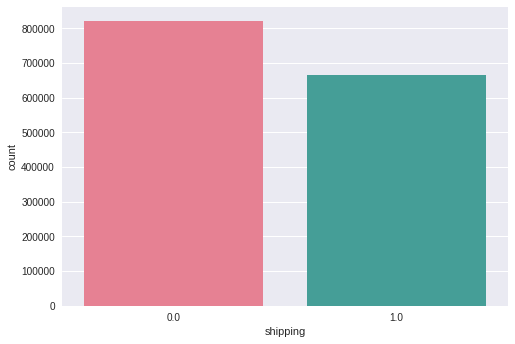

In [53]:
# 1 if shipping fee is paid by seller and 0 by buyer
ax = sns.countplot(x="shipping", data=mercari, palette="husl")

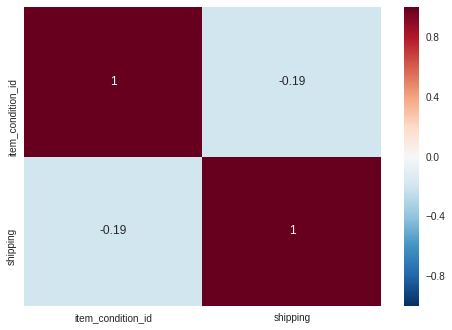

In [54]:
# correlation with above 2 features
numeric_category = ["item_condition_id", "shipping"]
cor = mercari[numeric_category].corr()
sns.heatmap(cor, annot=True)

### column "category_name" 1 to 5

In [0]:
max_length = 3
counter = 0
greater_index_lists = []

for category_text in mercari["category_name"]:
    if category_text == "no_category":
        counter += 1
        continue
    else:
        category_list = category_text.split("/")        
        if len(category_list) > 3:
            greater_index_lists.append(counter) 
            counter += 1
            if len(category_list) > max_length:
                max_length = len(category_list)
        else:
            counter += 1

In [21]:
len(greater_index_lists)

4392

In [57]:
counter

1484801

In [58]:
max_length

5

In [22]:
cat1 = []
cat2 = []
cat3 = []
cat4 = []
cat5 = []
counter = 0

for category_text in mercari["category_name"]:
    
    if category_text == "no_category":
        cat1.append(np.nan)
        cat2.append(np.nan)
        cat3.append(np.nan)
        cat4.append(np.nan)
        cat5.append(np.nan)
        counter += 1
    else:
        category_list = category_text.split("/")
        
        if len(category_list) == 3:
            cat1.append(category_list[0])
            cat2.append(category_list[1])
            cat3.append(category_list[2])
            cat4.append(np.nan)
            cat5.append(np.nan)
            counter += 1
        elif len(category_list) == 4:
            cat1.append(category_list[0])
            cat2.append(category_list[1])
            cat3.append(category_list[2])
            cat4.append(category_list[3])
            cat5.append(np.nan)
            counter += 1       
        elif len(category_list) == 5:
            cat1.append(category_list[0])
            cat2.append(category_list[1])
            cat3.append(category_list[2])
            cat4.append(category_list[3])
            cat5.append(category_list[4])
            counter += 1
        else:
            print("error")
            break
            
new_category = pd.DataFrame({"category_A": cat1, "category_B": cat2, "category_C": cat3, "category_D": cat4, "category_E": cat5})
#len(new_category)
counter

1483904

In [23]:
new_category.shape

(1483904, 5)

In [0]:
mercari.drop("category_name", axis=1, inplace=True)

In [25]:
mercari.shape

(1483904, 6)

In [0]:
mercari.reset_index(drop=True, inplace=True)

In [28]:
mercari_cat = pd.concat([mercari, new_category], axis=1)
mercari_cat.shape

(1483904, 11)

In [65]:
mercari_cat.head()

,train_id,name,item_condition_id,brand_name,shipping,item_description,category_A,category_B,category_C,category_D,category_E
0,0,MLB Cincinnati Reds T Shirt Size XL,3.0,no_brand,1.0,No description yet,Men,Tops,T-shirts,NaN,NaN
1,1,Razer BlackWidow Chroma Keyboard,3.0,Razer,0.0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,NaN,NaN
2,2,AVA-VIV Blouse,1.0,Target,1.0,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,NaN,NaN
3,3,Leather Horse Statues,1.0,no_brand,1.0,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,NaN,NaN
4,4,24K GOLD plated rose,1.0,no_brand,0.0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,NaN,NaN


In [29]:
a = list(mercari_cat["category_A"].unique())
len(a)

11

In [30]:
b = list(mercari_cat["category_B"].unique())
len(b)

114

In [68]:
for i in range(0, len(a)):
    if a[i] in b:
        print("duplicates!")

duplicates!
duplicates!
duplicates!


In [31]:
df_A = pd.concat([mercari_cat["category_A"], mercari_price], axis=1)
df_A.head()

,category_A,price,train_id
0,Men,10.0,0
1,Electronics,52.0,1
2,Women,10.0,2
3,Home,35.0,3
4,Women,44.0,4


In [70]:
df_A.shape

(1484806, 3)

In [0]:
plt.rcParams['figure.figsize'] = (400.0, 200.0)

It looks like category_A has some relationship with Price.  

In [0]:
# plt.figure(figsize=(2000, 800))
sns.catplot(x="category_A", y="price", kind="box", data=df_A);
plt.show();

In [32]:
df_B = pd.concat([mercari_cat["category_B"], mercari_price], axis=1)
df_B.head()

,category_B,price,train_id
0,Tops,10.0,0
1,Computers & Tablets,52.0,1
2,Tops & Blouses,10.0,2
3,Home Décor,35.0,3
4,Jewelry,44.0,4


In [0]:
plt.figure(figsize=(20, 12))
sns.catplot(x="category_B", y="price", kind="swarm", data=df_B);
plt.show();

## What I found till now about features
Slightly related with Price  
- item_condition_id
- shipping
   
Generally related with Price  
- category_name (SVD)
- brand_name ()

Not yet checked (tf-idf -> word2vec -> t-SNE)
- name
- item_description

### for "brand_name", I will use t-SNE/PCA to reduce about 5k categories to 2D/3D

In [33]:
# count unique value
len(mercari["brand_name"].unique())

4810

I will check the price distribution which has brand or not

In [34]:
len(mercari["brand_name"])

1483904

In [35]:
index_num = 0
no_brand_index = []
brand_index = []

for v in mercari["brand_name"]:
    if v == "no_brand":
        no_brand_index.append(index_num)
        index_num += 1
    else:
        brand_index.append(index_num)
        index_num += 1

print("Length of no_brand_index: ", len(no_brand_index))
print("Length of brand_index: ", len(brand_index))

Length of no_brand_index:  633273
Length of brand_index:  850631


In [0]:
sns.distplot(mercari.ix[no_brand_index, "brand_name"], color="skyblue", label="No Brand")
sns.distplot(mercari.ix[brand_index, "brand_name"], color="red", label="Brand Products")
sns.plt.legend()

# Preorocessing for NLP

I will treat two features "name" and "item_description" as text data.  

#### Process
1. Concat "name" and "item_description"
2. Remove all irrelevant characters such as 24 or @
3. Tokenize your text by separating it into individual words
4. Normalize all characters to lowercase, in order to treat words such as “hello”, “Hello”, and “HELLO” the same
5. Lemmatization (reduce words such as “am”, “are”, and “is” to a common form such as “be”)
6. Remove "stopwords"
7. Bag of words: TF-IDF
8. Dimensional Reduction: t-SNE and LDA

"name" and "item_description" -> BoW -> 2D or 3D

-----------------------------

* Bag of Words: CountVectorizer & TF-IDF is scaler: from word to scale
* Word Embedding: word2vec, doc2vec, seq2seq is semantic vector

In [36]:
mercari[["name", "item_description"]].head(20)

,name,item_description
0,MLB Cincinnati Reds T Shirt Size XL,No description yet
1,Razer BlackWidow Chroma Keyboard,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,Complete with certificate of authenticity
5,Bundled items requested for Ruie,"Banana republic bottoms, Candies skirt with ma..."
6,Acacia pacific tides santorini top,Size small but straps slightly shortened to fi...
7,Girls cheer and tumbling bundle of 7,You get three pairs of Sophie cheer shorts siz...
8,Girls Nike Pro shorts,Girls Size small Plus green. Three shorts total.
9,Porcelain clown doll checker pants VTG,I realized his pants are on backwards after th...


In [37]:
mercari[["name", "item_description"]].isnull().sum()

name                0
item_description    0
dtype: int64

In description, some data have "No description yet". I will remove this as stopword before.

In [0]:
no_desc = mercari[mercari["item_description"]=="No description yet"].index

In [39]:
type(no_desc)

pandas.core.indexes.numeric.Int64Index

In [40]:
len(no_desc)

82553

In [0]:
no_desc_list = list(no_desc)

In [43]:
mercari.ix[no_desc_list, "item_description"] = np.nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [44]:
mercari.isnull().sum()

train_id                 0
name                     0
item_condition_id        0
brand_name               0
shipping                 0
item_description     82553
dtype: int64

In [0]:
mercari["item_description"].fillna("", inplace=True)

In [46]:
mercari[["name", "item_description"]].head(20)

,name,item_description
0,MLB Cincinnati Reds T Shirt Size XL,
1,Razer BlackWidow Chroma Keyboard,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,Complete with certificate of authenticity
5,Bundled items requested for Ruie,"Banana republic bottoms, Candies skirt with ma..."
6,Acacia pacific tides santorini top,Size small but straps slightly shortened to fi...
7,Girls cheer and tumbling bundle of 7,You get three pairs of Sophie cheer shorts siz...
8,Girls Nike Pro shorts,Girls Size small Plus green. Three shorts total.
9,Porcelain clown doll checker pants VTG,I realized his pants are on backwards after th...


In [47]:
mercari_text = pd.concat([mercari["name"], mercari["item_description"]], axis=1)
mercari_text.head()

,name,item_description
0,MLB Cincinnati Reds T Shirt Size XL,
1,Razer BlackWidow Chroma Keyboard,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,Complete with certificate of authenticity


In [48]:
len(mercari_text)

1483904

In [0]:
name_list = []
desc_list = []

for name in mercari_text["name"]:
    name_list.append(name)

In [0]:
for desc in mercari_text["item_description"]:
    desc_list.append(desc)

In [51]:
len(name_list)

1483904

In [52]:
len(desc_list)

1483904

In [53]:
merge_text_list = []

for i in range(0, len(mercari_text)):
    merge_text = name_list[i] + " " + desc_list[i]
    merge_text_list.append(merge_text)
    
len(merge_text_list)

1483904

In [54]:
text_df = pd.DataFrame(merge_text_list, columns=["text"])
text_df.head()

,text
0,MLB Cincinnati Reds T Shirt Size XL
1,Razer BlackWidow Chroma Keyboard This keyboard...
2,AVA-VIV Blouse Adorable top with a hint of lac...
3,Leather Horse Statues New with tags. Leather h...
4,24K GOLD plated rose Complete with certificate...


In [55]:
len(merge_text_list)

1483904

2. Normalize all characters to lowercase, in order to treat words such as “hello”, “Hello”, and “HELLO” the same

In [56]:
text_df["text"] = text_df["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))
text_df["text"].head()

0                  mlb cincinnati reds t shirt size xl
1    razer blackwidow chroma keyboard this keyboard...
2    ava-viv blouse adorable top with a hint of lac...
3    leather horse statues new with tags. leather h...
4    24k gold plated rose complete with certificate...
Name: text, dtype: object

3. Remove all irrelevant characters: numbers, mark, emoji such as 24 or @

In [0]:
import re
import string

In [59]:
text_df["text"].head(20)

0                   mlb cincinnati reds t shirt size xl
1     razer blackwidow chroma keyboard this keyboard...
2     ava-viv blouse adorable top with a hint of lac...
3     leather horse statues new with tags. leather h...
4     k gold plated rose complete with certificate o...
5     bundled items requested for ruie banana republ...
6     acacia pacific tides santorini top size small ...
7     girls cheer and tumbling bundle of  you get th...
8     girls nike pro shorts girls size small plus gr...
9     porcelain clown doll checker pants vtg i reali...
10    smashbox primer . oz full size is oz for [rm] ...
11    new vs pi k body mists () new vs pink body mis...
12               black skater dress xl, great condition
13                                 sharpener and eraser
14    hold for dogs minnetonka boots authentic. sued...
15    sephora tarte birthday gift brand new. deluxe ...
16    glitter eyeshadow  glitter eyeshadows; one in ...
17    new: baby k'tan active baby carrier brand 

In [60]:
text_df["text"] = text_df["text"].str.replace('[^\w\s]','')
text_df["text"].head(20)

0                   mlb cincinnati reds t shirt size xl
1     razer blackwidow chroma keyboard this keyboard...
2     avaviv blouse adorable top with a hint of lace...
3     leather horse statues new with tags leather ho...
4     k gold plated rose complete with certificate o...
5     bundled items requested for ruie banana republ...
6     acacia pacific tides santorini top size small ...
7     girls cheer and tumbling bundle of  you get th...
8     girls nike pro shorts girls size small plus gr...
9     porcelain clown doll checker pants vtg i reali...
10    smashbox primer  oz full size is oz for rm in ...
11    new vs pi k body mists  new vs pink body mists...
12                black skater dress xl great condition
13                                 sharpener and eraser
14    hold for dogs minnetonka boots authentic suede...
15    sephora tarte birthday gift brand new deluxe t...
16    glitter eyeshadow  glitter eyeshadows one in b...
17    new baby ktan active baby carrier brand ne

In [58]:
text_df["text"] = text_df["text"].str.replace(r"\d+", "")
text_df["text"].head()

0                  mlb cincinnati reds t shirt size xl
1    razer blackwidow chroma keyboard this keyboard...
2    ava-viv blouse adorable top with a hint of lac...
3    leather horse statues new with tags. leather h...
4    k gold plated rose complete with certificate o...
Name: text, dtype: object

In [61]:
text_df["text"] = text_df["text"].str.replace(r"[︰-＠]", "")
text_df["text"].head(20)

0                   mlb cincinnati reds t shirt size xl
1     razer blackwidow chroma keyboard this keyboard...
2     avaviv blouse adorable top with a hint of lace...
3     leather horse statues new with tags leather ho...
4     k gold plated rose complete with certificate o...
5     bundled items requested for ruie banana republ...
6     acacia pacific tides santorini top size small ...
7     girls cheer and tumbling bundle of  you get th...
8     girls nike pro shorts girls size small plus gr...
9     porcelain clown doll checker pants vtg i reali...
10    smashbox primer  oz full size is oz for rm in ...
11    new vs pi k body mists  new vs pink body mists...
12                black skater dress xl great condition
13                                 sharpener and eraser
14    hold for dogs minnetonka boots authentic suede...
15    sephora tarte birthday gift brand new deluxe t...
16    glitter eyeshadow  glitter eyeshadows one in b...
17    new baby ktan active baby carrier brand ne

4. Tokenize your text by separating it into individual words

In [62]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [63]:
text_df["text"] = text_df["text"].apply(word_tokenize)
text_df["text"].head()

0          [mlb, cincinnati, reds, t, shirt, size, xl]
1    [razer, blackwidow, chroma, keyboard, this, ke...
2    [avaviv, blouse, adorable, top, with, a, hint,...
3    [leather, horse, statues, new, with, tags, lea...
4    [k, gold, plated, rose, complete, with, certif...
Name: text, dtype: object

5. Remove "stopwords"

In [66]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [68]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
text_df["text_nonstop"] = text_df["text"].apply(lambda x: [item for item in x if item not in stop_words])
text_df["text_nonstop"].head(20)

0              [mlb, cincinnati, reds, shirt, size, xl]
1     [razer, blackwidow, chroma, keyboard, keyboard...
2     [avaviv, blouse, adorable, top, hint, lace, ke...
3     [leather, horse, statues, new, tags, leather, ...
4     [k, gold, plated, rose, complete, certificate,...
5     [bundled, items, requested, ruie, banana, repu...
6     [acacia, pacific, tides, santorini, top, size,...
7     [girls, cheer, tumbling, bundle, get, three, p...
8     [girls, nike, pro, shorts, girls, size, small,...
9     [porcelain, clown, doll, checker, pants, vtg, ...
10    [smashbox, primer, oz, full, size, oz, rm, sep...
11    [new, vs, pi, k, body, mists, new, vs, pink, b...
12         [black, skater, dress, xl, great, condition]
13                                  [sharpener, eraser]
14    [hold, dogs, minnetonka, boots, authentic, sue...
15    [sephora, tarte, birthday, gift, brand, new, d...
16    [glitter, eyeshadow, glitter, eyeshadows, one,...
17    [new, baby, ktan, active, baby, carrier, b

6. Stemming and Lemmatization (reduce words such as “am”, “are”, and “is” to a common form such as “be”)

In [69]:
# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
text_df["text_nonstop"] = text_df["text_nonstop"].apply(lambda x: stemmer.stem(x))
text_df["text_nonstop"].head()

AttributeError: ignored

In [64]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
text_df["text"] = text_df["text"].apply(lambda x: lemmatizer.lemmatize(x))
text_df["text"].head()

7. Bag of words: TF-IDF

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.03)
tfidf_X = vectorizer.fit_transform(text_df["text"]).toarray()
# tfidf_X.get_feature_names()

index = tfidf_X.argsort(axis=1)[:,::-1]
feature_names = np.array(vectorizer.get_feature_names())
feature_words = feature_names[index]

n = 5  # top何単語取るか
m = 15  # 何記事サンプルとして抽出するか
for fwords, target in zip(feature_words[:m,:n], news20.target):
    # 各文書ごとにtarget（ラベル）とtop nの重要語を表示
    print(news20.target_names[target])
    print(fwords)

8. Dimensional Reduction: t-SNE and LDA

In [0]:
stop

In [0]:
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

# MLPClassifier

# Stacking with RMRegressor, XGBoost, NeuralNetwork

- Tf-idf: Feature Extraction for text data (BoW)
- word2vec: Vctorize from word to numerical data
- t-SNE: Dimensional Reduction

# ベクトル化しないで次元削除ってどういうこと？
## tf-idf -> t-SNE

countvectorizer & LDA SVD